<a href="https://colab.research.google.com/github/whbpt/GREMLIN_PYTORCH/blob/master/GREMLIN_pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_pytorch

This is a bare minimum version of GREMLIN (no gap removal, etc), intended for educational/demo purposes.  For the full version see [GREMLIN_TF_v2.1](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb) 

In [1]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

###reimplemented with pytorch by haobo wang, 20190323
# "THE APPLE CIDER LICENSE" :
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy me an apple cider in return.

## Load some libraries

In [2]:
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn.functional as F
import torch.nn.modules as modules
from torch.autograd import Variable
from torch import optim

## Convert FASTA to MSA np.array()

In [3]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)

def one_hot(msa,states):
  one = np.eye(states)
  return one[msa]

def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, one_hot(msa_ori,states)

## load example

In [4]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [5]:
names,seqs = parse_fasta("4FAZA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(817, 62)
(817, 62, 21)


In [6]:
# collecting some information about input msa
N = msa.shape[0] # number of sequences
L = msa.shape[1] # length of sequence
A = msa.shape[2] # number of states (or categories)


In [14]:
class GREMLIN(torch.nn.Module):
  def __init__(self,L,A):
    super(GREMLIN, self).__init__()
    self.W0 = torch.nn.Parameter(torch.zeros(L*A,L*A), requires_grad=True)
    self.b0 = torch.nn.Parameter(torch.zeros(L*A), requires_grad=True)
    self.MASK = (1.0 -torch.eye(L*A))
  def forward(self,X):
    X = X.reshape(-1,L*A)
    W = (self.W0+self.W0)/2.0 * self.MASK
   
    MSA_pred = (X.mm(W)+self.b0).reshape(-1,L,A)
    loss = torch.sum(- MSA_Input * F.log_softmax(MSA_pred, -1))
    L2_w = torch.square(W).sum() * 0.01 * 0.5 *L*A
    L2_b = torch.square(self.b0).sum() * 0.01
    loss = loss + L2_w + L2_b
    return loss

In [15]:
class Model(torch.nn.Module):
  def __init__(self,L,A):
    super(Model, self).__init__()
    self.GREMLIN_ = GREMLIN(L,A)
    
  def forward(self,X):
    loss = self.GREMLIN_(X)
    return loss

In [16]:
#enviroment setting
device = torch.device("cuda:0") # Uncomment this to run on GPU
MSA_Input = torch.from_numpy(msa.astype(np.float32))

model = Model(L,A)
learning_rate = 0.1*np.log(N)/L
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for t in range(100):

    loss = model(MSA_Input)      
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    
    if (t) % (int(100/10)) == 0: 
      print(t, loss.item())
    
    

0 154214.890625
10 53276.9296875
20 43932.88671875
30 38946.69140625
40 36722.1328125
50 35624.41796875
60 34983.57421875
70 34565.546875
80 34268.75390625
90 34044.26953125


In [17]:
w = model.GREMLIN_.W0.detach().numpy()
w = (w+w.T).reshape(L,A,L,A)

## get contacts

In [18]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:,:,:]),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

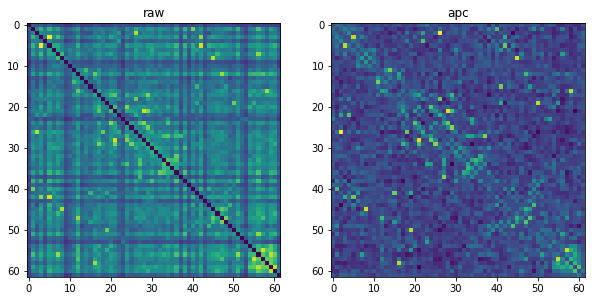

In [19]:
raw, apc = get_mtx(w)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()